Epoch 1/100, cost: 0.7753410184573998 test cost: 0.33780513064755613
Epoch 2/100, cost: 0.2975553490902819 test cost: 0.2549674465303839
Epoch 3/100, cost: 0.23632415602913506 test cost: 0.2121622375263256
Epoch 4/100, cost: 0.20078236261824856 test cost: 0.19595780724593864
Epoch 5/100, cost: 0.17268392329277438 test cost: 0.16919149637278408
Epoch 6/100, cost: 0.15917281848395995 test cost: 0.1489081348036181
Epoch 7/100, cost: 0.14507921855653563 test cost: 0.15744280565041618
Epoch 8/100, cost: 0.13317433387011157 test cost: 0.14701063814959134
Epoch 9/100, cost: 0.1250731870394448 test cost: 0.14209308488629355
Epoch 10/100, cost: 0.11867069146265621 test cost: 0.13221998077205957
Epoch 11/100, cost: 0.11104779716117986 test cost: 0.13565999956963318
Epoch 12/100, cost: 0.10732517266102898 test cost: 0.14204610151717106
Epoch 13/100, cost: 0.10241204302682957 test cost: 0.134948207217653
Epoch 14/100, cost: 0.09641730319127818 test cost: 0.1371104378894006


KeyboardInterrupt: 

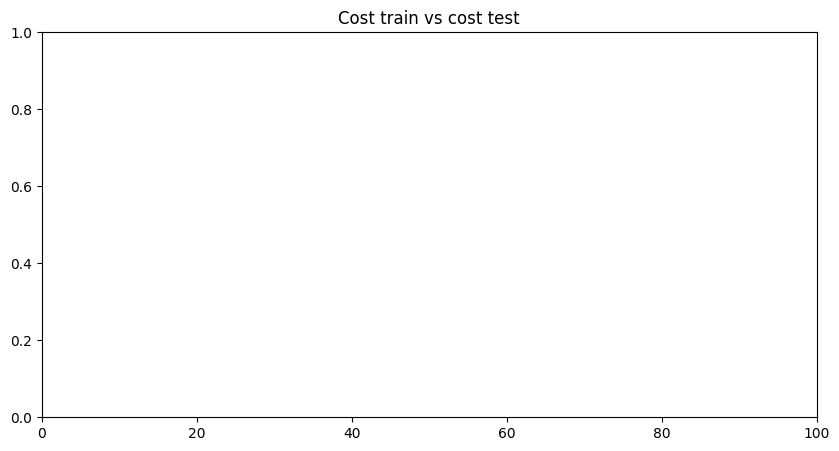

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

data = np.load('mnist_data.npz')
train_X = data['train_X']
train_Y = data['train_Y']
test_X = data['test_X']
test_Y = data['test_Y']

def split_data(data, batch_size):
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

def softmax(y: np.ndarray) -> np.ndarray:
    exp_y = np.exp(y - np.max(y, axis=1, keepdims=True))
    return exp_y / np.sum(exp_y, axis=1, keepdims=True)

def classify(y: np.ndarray, label: np.ndarray):
    return np.sum(np.argmax(y, axis=1) == np.argmax(label, axis=1))

def cross_entropy(y: np.ndarray, label: np.ndarray):
    return np.mean(-np.sum(label * np.log(y), axis=1))

def sigmoid(x: np.ndarray):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x: np.ndarray):
    sig = sigmoid(x)
    return sig * (1 - sig)

def forward_prop(x: np.array, w_1: np.array, b_1: np.array, w_2: np.array, b_2: np.array):
    global DROPOUT_RATE
    z_1 = x.dot(w_1) + b_1
    a_1 = sigmoid(z_1)
    # dropout pe hidden layer
    a_1 = np.where(np.random.rand(*a_1.shape) < DROPOUT_RATE, 0, a_1)
    a_1 /= (1-DROPOUT_RATE)
    z_2 = a_1.dot(w_2) + b_2
    y = softmax(z_2)
    return y, z_1, a_1

def back_prop(x: np.array, y: np.array, label: np.array, w_1: np.array, b_1: np.array, w_2: np.array, b_2: np.array, z_1: np.array, a_1: np.array):
    global ALPHA, BATCH_SIZE
    error_out = y - label
    error_hidden = error_out.dot(w_2.T) * sigmoid_derivative(z_1)

    grad_w_2 = a_1.T.dot(error_out)
    grad_b_2 = np.mean(error_out, axis=0) / BATCH_SIZE
    grad_w_1 = x.T.dot(error_hidden)
    grad_b_1 = np.mean(error_hidden, axis=0) / BATCH_SIZE

    w_2 -= ALPHA * grad_w_2
    b_2 -= ALPHA * grad_b_2
    w_1 -= ALPHA * grad_w_1
    b_1 -= ALPHA * grad_b_1


def train_mini_batch(x: np.array, label: np.array):
    global w_1, b_1, w_2, b_2
    y, z_1, a_1 = forward_prop(x, w_1, b_1, w_2, b_2)
    back_prop(x, y, label, w_1, b_1, w_2, b_2, z_1, a_1)
    return cross_entropy(y, label)

def train(dataset):
    global BATCH_SIZE

    batches = split_data(dataset, BATCH_SIZE)

    cost = 0
    for batch in batches:
        x = np.array([data[0] for data in batch])
        label = np.array([data[1] for data in batch])
        cost += train_mini_batch(x, label)
    return cost / len(batches)

def test(x: np.array, label: np.array):
    global w_1, b_1, w_2, b_2
    y, _, _ = forward_prop(x, w_1, b_1, w_2, b_2)
    return cross_entropy(y, label)

# Definire variabile globale
w_1 = np.random.randn(784, 100) * 0.01
b_1 = np.zeros(100)
w_2 = np.random.randn(100, 10) * 0.01
b_2 = np.zeros(10)

ALPHA = 0.02
EPOCHS = 100
BATCH_SIZE = 100
DROPOUT_RATE = 0.1

train_data = list(zip(train_X, train_Y))
train_data_len = len(train_data)

# plot pentru grafic
epochs, cost_train, cost_test = [], [], []
plt.figure(figsize=(10, 5))
plt.xlim(0, EPOCHS)
plt.title('Cost train vs cost test')


start_time = time.time()

for i in range(EPOCHS):
    if i == 20:
        ALPHA = 0.01
    np.random.shuffle(train_data)
    avg_cost = train(train_data)
    avg_cost_test = test(test_X, test_Y)
    print(f'Epoch {i + 1}/{EPOCHS}, cost: {avg_cost} test cost: {avg_cost_test}')
    
    epochs.append(i)
    cost_train.append(avg_cost)
    cost_test.append(avg_cost_test)


plt.plot(epochs, cost_train, label="Training Cost", color="blue")
plt.plot(epochs, cost_test, label="Testing Cost", color="orange")
plt.legend()
plt.ylim(0, max(cost_test))
plt.show()
end_time = time.time()

print(f'Training took {end_time - start_time} seconds')
# Save the model
np.savez('model.npz', w_1 = w_1, b_1 = b_1, w_2 = w_2, b_2 = b_2)